In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
current_palette = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython.display import clear_output
sns.set_style('darkgrid')
np.random.seed(0)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, accuracy_score
from sklearn.pipeline import Pipeline
import obtain as ob
from sklearn.decomposition import PCA
pca= PCA(n_components=50)

In [2]:
poverty_df = ob.upload_county_acs_data('ACSDP5Y2012.DP03_data_with_overlays_2019-12-31T163946.csv')
df = poverty_df
population_df = ob.upload_county_acs_data('ACSDP5Y2012.DP05_data_with_overlays_2019-12-31T193014.csv')
df = ob.merge_acs_data(df,population_df)
df = ob.remove_duplicate_countystate(df) 
num_df, object_df = ob.separate_num_columns(df)
pull_columns = [i for i in num_df.columns]
cms_df = ob.cms_data()
df = cms_df.merge(df.drop(columns =['County','State']), how='left', on=['CountyState'])
target = 'ratio_to_max_payment'
cms_labels =ob.cms_procedure_dummy_labels(df).columns


### Model with Only CMS Procedure Labels and the Max Payment for each procedure

In [3]:
X = ob.cms_procedure_dummy_labels(df)

X['max_payment'] = df['max_payment']
y = np.log(df[target])

In [4]:

data_train, data_test, target_train, target_test = train_test_split(X, y, test_size = 0.25)

MSE score: 0.059291496092455875
R-sq score: 0.5176494443733016
R-sq score train: 0.5143167673878174


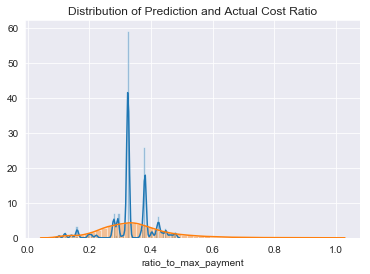

In [5]:
regressor = DecisionTreeRegressor(max_depth=6)
regressor.fit(data_train, target_train)
y_pred = regressor.predict(data_test)
y_PRED = regressor.predict(data_train)
print('MSE score:', mse(target_test, y_pred))
print('R-sq score:', r2_score(target_test,y_pred))
print('R-sq score train:', r2_score(target_train,y_PRED))
sns.distplot(np.exp(y_PRED), label='Predicted').set_title('Distribution of Prediction and Actual Cost Ratio')
sns.distplot(np.exp(target_train))


In [6]:
num_df, object_df = ob.separate_num_columns(df)
X, cms_not = ob.remove_cms(num_df)
X['max_payment'] = df['max_payment']
y = np.log(df[target])

In [7]:
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size = 0.25)

MSE score: 0.05077184376315423
R-sq score: 0.5825906766516146
R-sq score train: 0.5897794100961931


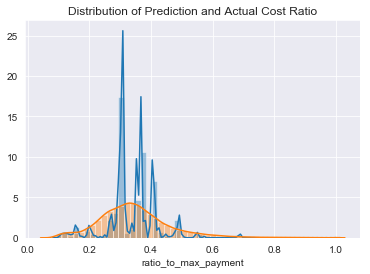

In [8]:
regressor = DecisionTreeRegressor(max_depth=6)
regressor.fit(data_train, target_train)
y_pred = regressor.predict(data_test)
y_PRED = regressor.predict(data_train)
print('MSE score:', mse(target_test, y_pred))
print('R-sq score:', r2_score(target_test,y_pred))
print('R-sq score train:', r2_score(target_train,y_PRED))
sns.distplot(np.exp(y_PRED), label='Predicted').set_title('Distribution of Prediction and Actual Cost Ratio')
sns.distplot(np.exp(target_train))


In [9]:
feature_dict = {}
for i in pull_columns:
    feature_dict[i] = 0
for i in cms_labels:
    feature_dict[i] = 0
feature_dict['max_payment'] = 0

In [10]:
num_cycle = 20
n_estimator = 100
feature_ = 5

In [11]:
score = 1266227.0289008094
for cycle in range(0,num_cycle):
    data_train, data_test, target_train, target_test = train_test_split(X, y, test_size = 0.25)
    model_list = []
    regressor = DecisionTreeRegressor(max_depth=6)
    for i in range(0,n_estimator):
        columns = [j for j in np.random.choice(pull_columns, feature_)]
        columns.append('max_payment')
        for k in cms_labels:
            columns.append(k)
        transfer_model =regressor.fit(data_train[columns], target_train)
        model_list.append({'model':transfer_model, 'feature':columns})
    test = np.zeros(len(target_test))
    train = np.zeros(len(target_train))
    for i in model_list:
        model = i['model']
        y_pred = model.predict(data_test[i['feature']])
        y_PRED = model.predict(data_train[i['feature']])
        test += y_pred
        train += y_PRED
    test = test/len(model_list)
    train = train/len(model_list)
    for j,i in enumerate(model_list[0]['feature']):
        feature_dict[i] += model_list[0]['model'].feature_importances_[j]
    if mse(test, y_pred) < score:
        print('MSE score:', mse(test, y_pred),'R-sq score:', r2_score(test,y_pred), 
          'R-sq score train:', r2_score(train,y_PRED))
        score = mse(test, y_pred)
        final_model = model_list

MSE score: 0.013250326565323448 R-sq score: 0.7760957624106026 R-sq score train: 0.7709811671117355
MSE score: 0.011203833049259142 R-sq score: 0.8125210835271656 R-sq score train: 0.8152604109476737
MSE score: 0.009165575401560275 R-sq score: 0.833119945228317 R-sq score train: 0.8279042479234568
MSE score: 0.008177534718152383 R-sq score: 0.8545436101723395 R-sq score train: 0.8535688993957643
MSE score: 0.007323543796062308 R-sq score: 0.8950992513566696 R-sq score train: 0.8977951370118411
MSE score: 0.0055951711464860485 R-sq score: 0.9057953828841898 R-sq score train: 0.9082267483735977


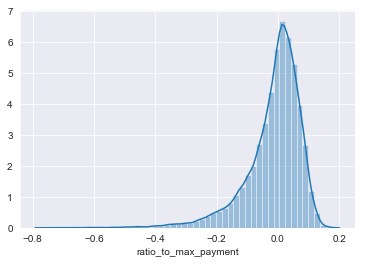

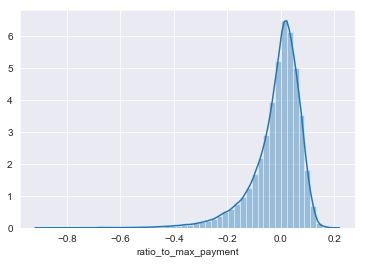

0.09134314588273593

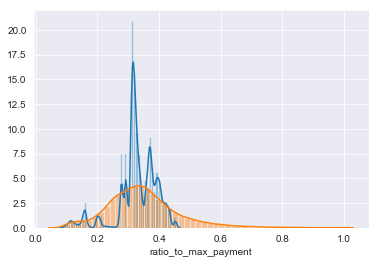

In [12]:
test = np.zeros(len(target_test))
train = np.zeros(len(target_train))
for i in final_model:
    model = i['model']
    y_pred = model.predict(data_test[i['feature']])
    y_PRED = model.predict(data_train[i['feature']])
    test += y_pred
    train += y_PRED
test = test/len(model_list)
train = train/len(model_list)

sns.distplot(np.exp(test)-np.exp(target_test))

plt.show()
sns.distplot(np.exp(train)-np.exp(target_train))

plt.show()
sns.distplot(np.exp(train))
sns.distplot(np.exp(target_train))
(np.exp(test)-np.exp(target_test)).std()

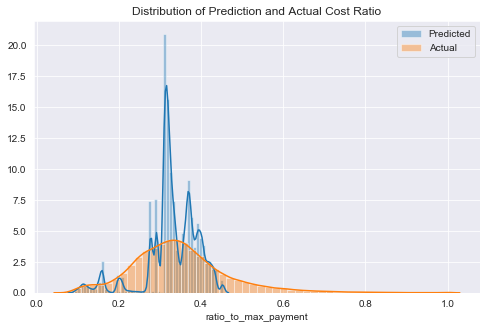

In [20]:
plt.figure(figsize=(8,5))
plt.title('Distribution of Prediction and Actual Cost Ratio')
sns.distplot(np.exp(train), label='Predicted')
sns.distplot(np.exp(target_train), label='Actual')

plt.legend()

In [14]:
test = np.zeros(len(X))
train = np.zeros(len(target_train))
for i in final_model:
    model = i['model']
    y_pred = model.predict(X[i['feature']])
    y_PRED = model.predict(data_train[i['feature']])
    test += y_pred
    train += y_PRED
test = test/len(model_list)
train = train/len(model_list)

ValueError: operands could not be broadcast together with shapes (163065,) (40767,) 

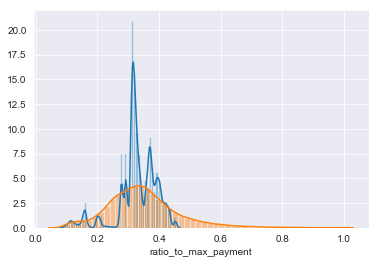

In [15]:
sns.distplot(np.exp(train))
sns.distplot(np.exp(target_train))
(np.exp(test)-np.exp(target_test)).std()